# Selection of a site for a temporary COVID-19 hospital in Lagos, Nigeria

## Introduction

2020 was a remarkable year that saw the introduction of COVID-19 as a global pandemic. COVID-19, a highly infectious respiratory disease caused by the SARS-CoV-2 coronavirus, caused flu-like and pneumonia-like symptoms, with more severe cases requiring hospitalization and in the worst case causing death. The mortality of the disease appeared to be correlated with the age and other comorbidity factors of the infected patient, such as diabetes and obesity. The virus was thought to have originated from Wuhan, China and had quickly spread across the world, with some countries such as USA, Italy, and Spain exceeding the case count within China. The high case count had quickly overwhelmed the hospitals of these countries, causing the mortality of the disease to rise sharply as vulnerable patients were unable to receive adequate treatment from the overwhelmed hospitals and died. Many nations across the world have implemented drastic population control measures to restrict movement and public gatherings, including quarantines and lockdowns, in a bid to slow the spread of the virus and alleviate the number of cases their hospitals would encounter at once.

As of April 18, 2020, COVID-19 is present within Lagos, Nigeria, and case counts, including severe cases, have been steadily rising. Hospitals in Lagos are at risk of being overwhelmed by the steadily increasing case counts, especially severe cases requiring hospitalization and intensive care. This project investigates what would be an ideal site for a temporary COVID-19 hospital in Lagos in anticipation of the expected surge of severe cases requiring hospitalization in intensive care. The temporary hospital would be expected to be similar to the Huoshenshan Hospital or Leishenshan Hospital used in Wuhan. The analysis will include the selection of a site within Lagos that can best accommodate the highest concentration of total potential severe cases of COVID-19 that would require hospitalization in intensive care not already served by Lagos' current hospital infrastructure. Other considerations, such as build timeline, cost, political response, and other feasibility-related issues, are not in scope of this report. The report would be expected to be useful for any city planner or healthcare organization that is interested in looking at locations for deploying a temporary hospital within Lagos that can maximize its impact on treating the very sick while minimizing the physical distance they will need to travel to get there.

## Data

The following sources of data were used to perform analysis:

Demographic data of lagos various neighbourhoods was taken from Nigeria Open Data Portal https://nigeria.opendataforafrica.org/.

Infection rates will be assumed to be at a hypothetical even rate across neighbourhoods. Current infections will not be used owing to the real-time and evolving nature of the data.

Hospitalization rates requiring intensive care for COVID-19 were scraped from Center for Disease Control's Morbidity and Mortality Weekly Report, February 12–March 16, 2020. The figures for US are assumed to be equivalent to Nigerian hospitalization rates.

Locations of current hospitals in Lagos were called from the Foursquare developer API.

Capacity of Lagos hospitals' intensive care units were sourced from Canadian Institute for Health Information.
Eligible sites for temporary hospitals would include unbuilt land in Lagos that is not expected to be used for erecting other buildings. Parks and Stadiums are assumed to be the best fit, and for the purposes of this analysis all parks will be assumed to be flat and without any significant structures already built on them. Location and size data for parks were taken from Lagos Open Data Portal - Parks.

To calculate the number and location of hypothetical severe cases of COVID-19 requiring hospitalization in Lagos:

Determine the demographics of Lagos's neighbourhoods.
Multiply the demographics by the hypothetical rate of infection and rate of hospitalization requiring intensive care by age cohort.
Map the hypothetical intensive care cases to their Lagos neighbourhoods.
To determine current hospital capacity and locations:

Determine hospitals in Lagos with intensive case units.
Search their coordinates using Foursquare.
Map their location and capacity to neighbourhoods in Lagos.
To evaluate potential sites for temporary COVID-19 hospital:

Map the parks of Lagos and determine their size.
Determine the capacity of a hypothetical temporary hospital by interpolating or extrapolating from Huoshenshan Hospital and Leishenshan Hospital's footprints and bed capacities.
Map the hypothetical hospitals to the neighbourhoods of Lagos
To decide which site is most suitable:

Determine if there are any underserved neighbourhoods in Lagos based on distance from existing hospitals and capacities of those hospitals.
Determine which hypothetical hospital can best alleviate the most underserved clusters.
If there are sites large enough to accommodate all potential intensive care cases, determine the site that minimizes travel distance for these patients.

## Key Assumptions

For the purposes of modelling, the following assumptions about patients will be made:

1. Patients that require intensive care are assumed to need it for the duration of the pandemic; patients do not die, but they do not recover either.
2. Patients will appear all at once, and they will be served by hospitals according to their proximity to them.
3. The quality of care at all hospitals are the same, and patients will not enter or leave Lagos to seek treament.
4. Hospital networks will have their capacities concentrated on the first single hospital identified.

#### Importing Relevant Libraries

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import math 

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install geopandas
import geopandas as gp # convert JSON data into dataframes

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install shapely #library to handle shape analysis
from shapely.geometry import shape, Point # convert locations into geometric points and shapes

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 931kB 11.9MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 44.3MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 32.1MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 29.7MB/s eta 0:00:01
     |████████████████████████████████| 92kB 9.7MB/s  eta 0:00:01
Libraries imported.


## Determining the number of potential COVID-19 patients in Lagos

#### Importing Lagos State's demographic data

In [5]:
df_lagdemo = pd.read_html('https://www.citypopulation.de/php/nigeria-admin.php?adm1id=NGA025',skiprows=0)[0]
df_lagdemo

,Name,Status,PopulationCensus1991-11-26,PopulationCensus2006-03-21,PopulationProjection2016-03-21,Unnamed: 5
0,Lagos,State,5725116,9113605,12550600,NaN
1,Agege,Local Government Area,417981,461743,635900,→
2,Ajeromi-Ifelodun,Local Government Area,593561,687316,946500,→
3,Alimosho,Local Government Area,430890,1319571,1817200,→
4,Amuwo-Odofin,Local Government Area,225823,328975,453000,→
5,Apapa,Local Government Area,154477,222986,307100,→
6,Badagry,Local Government Area,119267,237731,327400,→
7,Epe,Local Government Area,101464,181734,250300,→
8,Eti-Osa,Local Government Area,157387,283791,390800,→
9,Ibeju/Lekki,Local Government Area,24937,117793,162200,→


We drop the Population Data for Census 1991 and Census 2006 and the Unnamed row with empty entries

In [10]:
#drop the cells having Nan and Population for Census for 1991 and 2006
df_lagos = df_lagdemo.drop(['PopulationCensus1991-11-26', 'PopulationCensus2006-03-21', 'Unnamed: 5'], axis=1)


# resets the index after dropping the rows
df_lagdemo.reset_index(drop=True, inplace=True)

df_lagos

,Name,Status,PopulationProjection2016-03-21
0,Lagos,State,12550600
1,Agege,Local Government Area,635900
2,Ajeromi-Ifelodun,Local Government Area,946500
3,Alimosho,Local Government Area,1817200
4,Amuwo-Odofin,Local Government Area,453000
5,Apapa,Local Government Area,307100
6,Badagry,Local Government Area,327400
7,Epe,Local Government Area,250300
8,Eti-Osa,Local Government Area,390800
9,Ibeju/Lekki,Local Government Area,162200


#### Importing COVID-19 Data for Italy

In [11]:
df_Italycovid = pd.read_html('https://www.citypopulation.de/en/italy/covid/',skiprows=0)[0]
df_Italycovid

,Name,Status,Casescount2020-02-25,Casescount2020-03-04,Casescount2020-03-12,Casescount2020-03-20,Casescount2020-03-28,Casescount2020-04-05,Casescount2020-04-09,Casescount2020-04-13,Casescount2020-04-17,Unnamed: 11
0,Abruzzo,Region,0,7,84,449,1133,1703,1931,2213,2443,→
1,Chieti,Province,0,0,20,80,229,325,369,465,553,→
2,L'Aquila,Province,0,1,8,29,88,179,199,220,233,→
3,Pescara,Province,0,1,48,259,512,727,805,930,1042,→
4,Teramo,Province,0,3,8,81,304,472,558,598,615,→
5,Basilicata,Region,0,1,8,52,182,278,303,319,337,→
6,Matera,Province,0,0,3,9,76,136,146,155,170,→
7,Potenza,Province,0,1,5,43,106,142,157,164,167,→
8,Calabria,Region,0,1,33,207,555,795,874,928,991,→
9,Catanzaro,Province,0,0,3,34,118,157,173,183,195,→


In [65]:
df_Italycovid.set_index('Name', inplace=True)
df_Italycovid

,Status,Casescount2020-02-25,Casescount2020-03-04,Casescount2020-03-12,Casescount2020-03-20,Casescount2020-03-28,Casescount2020-04-05,Casescount2020-04-09,Casescount2020-04-13,Casescount2020-04-17,Unnamed: 11
Name,,,,,,,,,,,
Abruzzo,Region,0,7,84,449,1133,1703,1931,2213,2443,→
Chieti,Province,0,0,20,80,229,325,369,465,553,→
L'Aquila,Province,0,1,8,29,88,179,199,220,233,→
Pescara,Province,0,1,48,259,512,727,805,930,1042,→
Teramo,Province,0,3,8,81,304,472,558,598,615,→
Basilicata,Region,0,1,8,52,182,278,303,319,337,→
Matera,Province,0,0,3,9,76,136,146,155,170,→
Potenza,Province,0,1,5,43,106,142,157,164,167,→
Calabria,Region,0,1,33,207,555,795,874,928,991,→


We'll proceed to drop the row with empty data

In [12]:
df_italycovid = df_Italycovid.drop('Unnamed: 11' , axis=1)
df_italycovid

,Name,Status,Casescount2020-02-25,Casescount2020-03-04,Casescount2020-03-12,Casescount2020-03-20,Casescount2020-03-28,Casescount2020-04-05,Casescount2020-04-09,Casescount2020-04-13,Casescount2020-04-17
0,Abruzzo,Region,0,7,84,449,1133,1703,1931,2213,2443
1,Chieti,Province,0,0,20,80,229,325,369,465,553
2,L'Aquila,Province,0,1,8,29,88,179,199,220,233
3,Pescara,Province,0,1,48,259,512,727,805,930,1042
4,Teramo,Province,0,3,8,81,304,472,558,598,615
5,Basilicata,Region,0,1,8,52,182,278,303,319,337
6,Matera,Province,0,0,3,9,76,136,146,155,170
7,Potenza,Province,0,1,5,43,106,142,157,164,167
8,Calabria,Region,0,1,33,207,555,795,874,928,991
9,Catanzaro,Province,0,0,3,34,118,157,173,183,195


#### Importing COVID_19 Data for Nigeria

In [81]:
df_Nigeriacovid = pd.read_html('https://covid19.ncdc.gov.ng/',skiprows=0)[3]
df_Nigeriacovid

,States Affected,No. of Cases (Lab Confirmed),No. of Active Cases,No. Discharged,No of Deaths
0,Lagos,283,182,90,11
1,Abuja FCT,69,44,23,2
2,Kano,27,26,0,1
3,Osun,20,3,17,0
4,Edo,15,8,6,1
5,Oyo,15,10,5,0
6,Ogun,10,5,5,0
7,Kwara,9,9,0,0
8,Katsina,9,8,0,1
9,Bauchi,6,6,0,0


In [92]:
df_Nigeriacovid.set_index('States Affected', inplace=True)
df_Nigeriacovid

,No. of Cases (Lab Confirmed),No. of Active Cases,No. Discharged,No of Deaths
States Affected,,,,
Lagos,283,182,90,11
Abuja FCT,69,44,23,2
Kano,27,26,0,1
Osun,20,3,17,0
Edo,15,8,6,1
Oyo,15,10,5,0
Ogun,10,5,5,0
Kwara,9,9,0,0
Katsina,9,8,0,1


Data of Total tests conducted

In [50]:
df_NigeriacovidTest = pd.read_html('https://covid19.ncdc.gov.ng/',skiprows=0)[2]
df_NigeriacovidTest

,0,1
0,Total Samples Tested,> 7153
1,Total Confirmed cases,493
2,Discharged,159
3,Death,17


## Visualize Lagos Demographic Data, Italy Covid Data, Nigeria Covid Data and Total Tests Conducted in Nigeria

Import Libraries to visualize

In [28]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


#### Nigerian COVID Cases

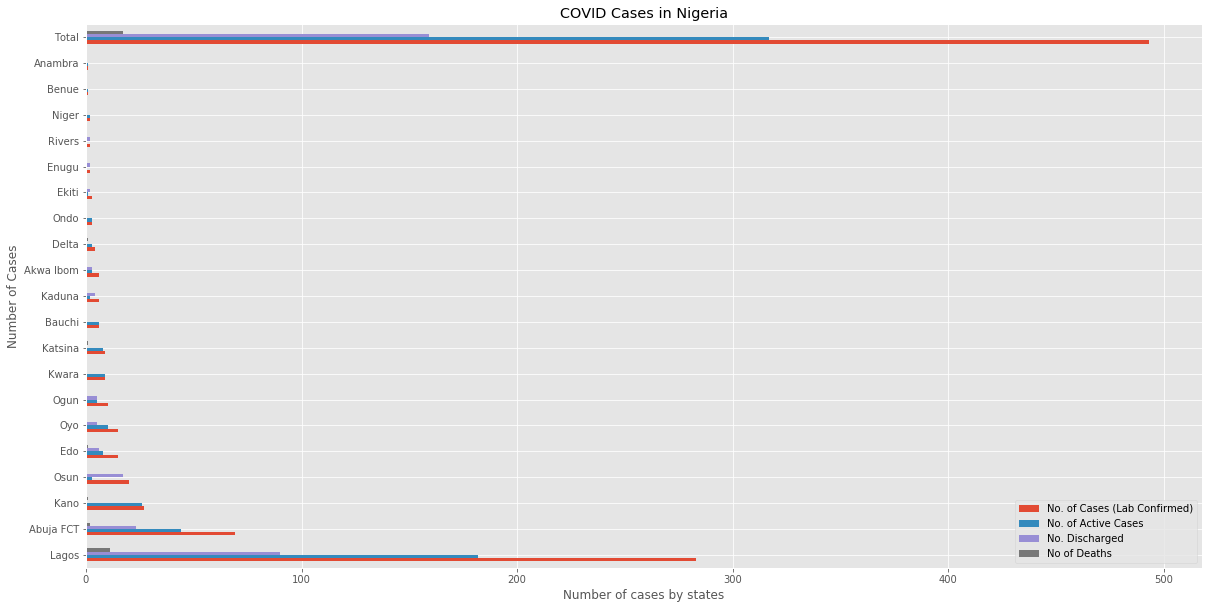

In [63]:
df_Nigeriacovid.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )

plt.title('COVID Cases in Nigeria')
plt.ylabel('Number of Cases')
plt.xlabel('Number of cases by states')

plt.show()

### Italy Covid Cases

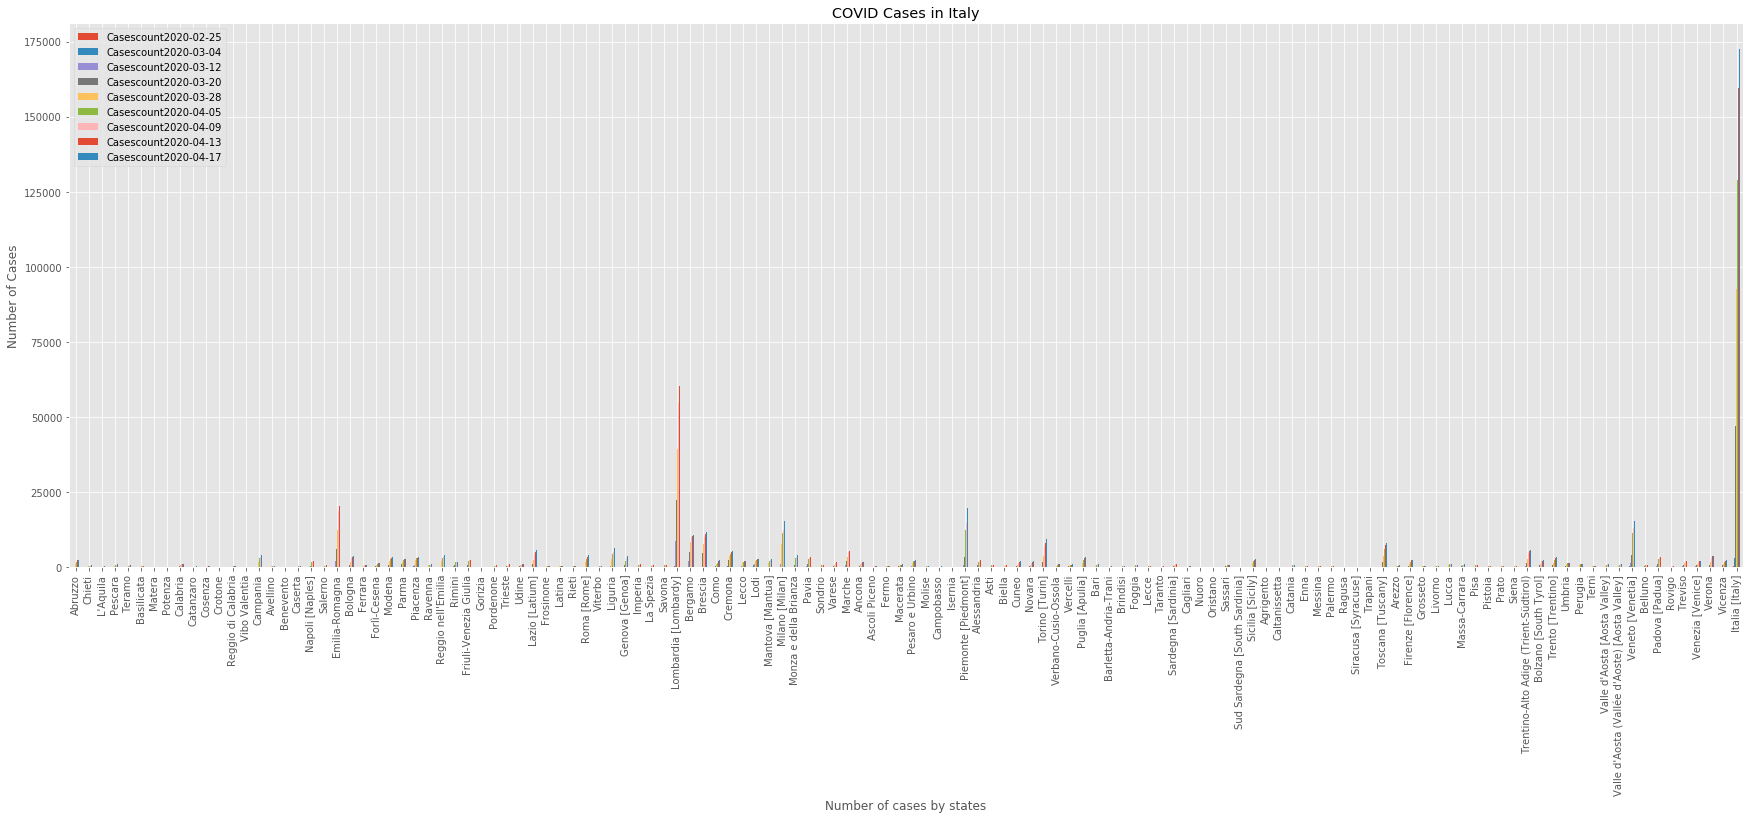

In [72]:
df_Italycovid.plot(kind='bar', 
             stacked=False,
             figsize=(30, 10), # pass a tuple (x, y) size
             )

plt.title('COVID Cases in Italy')
plt.ylabel('Number of Cases')
plt.xlabel('Number of cases by states')

plt.show()

### Importing Nigeria States GeoJson Data

In [77]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/deldersveld/topojson/master/countries/nigeria/nigeria-states.json') as response:
    nig_geo = json.load(response)
print('JSON file loaded!')

JSON file loaded!


#### Conclusion and Recommendation

A temporary hospital for treating COVID-19 patients requiring intensive care can be built in Lagos in the style of Wuhan's Huoshenshan Hospital and Leishenshan Hospital large enough to treat all of the projected COVID-19 patients in Lagos requiring intensive care. The location was chosen such that it minimizes the travel necessary for all the patients not served by Toronto's current hospital infrastructure to get to the site.

For next steps, the cost and timeline of building such a hospital could be investigated. There could be certain political ramifications, such as the loss of a major green space in the middle of the city, as well as the dissatisfaction of nearby residents who may not feel comfortable with a large influx of COVID-19 patients in the area. This would require extra effort in convincing them to overcome their NIMBYism.